In [1]:

import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
from IPython.display import Image
import os 
import sys
import pydotplus


In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from visualization import *


Let's explore the data that we have trained the model using mlflow which are saved. 

In [4]:
test_feature = pd.read_csv("../features/test_features.csv")
test_feature.head(5)

,experiment,hour,date_of_week,date_of_month,device_make,platform_os,browser
0,1,0,4,10,10,1,1
1,1,21,3,9,0,1,0
2,0,15,4,3,0,1,0
3,1,3,2,8,0,1,0
4,1,20,3,9,0,1,0


In [5]:
test_labels = pd.read_csv("../features/test_labels.csv")
test_labels.head(5)

,aware
0,1
1,0
2,0
3,0
4,1


In [6]:
feature_columns = [f.replace('_', ' ').capitalize() for f in test_feature]
feature_columns

['Experiment',
 'Hour',
 'Date of week',
 'Date of month',
 'Device make',
 'Platform os',
 'Browser']

In [7]:
test_feature

,experiment,hour,date_of_week,date_of_month,device_make,platform_os,browser
0,1,0,4,10,10,1,1
1,1,21,3,9,0,1,0
2,0,15,4,3,0,1,0
3,1,3,2,8,0,1,0
4,1,20,3,9,0,1,0
...,...,...,...,...,...,...,...
120,1,10,4,3,0,1,0
121,1,4,0,6,0,1,0
122,1,21,6,5,0,1,0
123,1,21,3,9,0,1,1


### Logistic Regression



In [8]:
model = pickle.load(open("../models/logistic_model.pickle", "rb"))
model


LogisticRegression(random_state=42, solver='newton-cg')

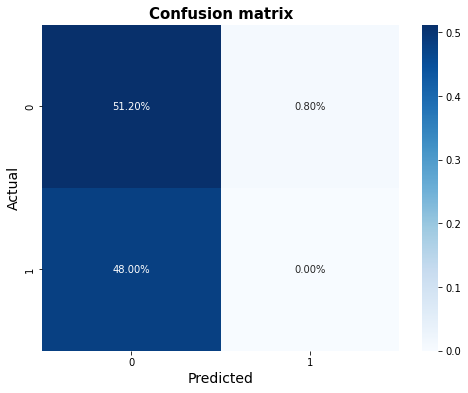

In [9]:
y_preds = model.predict(test_feature)
plot_confusion_metrics(test_labels, y_preds)

### Important Feature


In [10]:
imp_featur = pd.DataFrame({"Important Feature":model.coef_[0]})
imp_featur['Feature'] = feature_columns
imp_featur = imp_featur.set_index('Feature')
imp_featur = imp_featur.sort_values(by=['Important Feature'], ascending=False)
imp_featur

,Important Feature
Feature,
Platform os,0.59
Experiment,0.05
Hour,0.02
Date of week,0.01
Date of month,0.01
Device make,0.00
Browser,-0.01


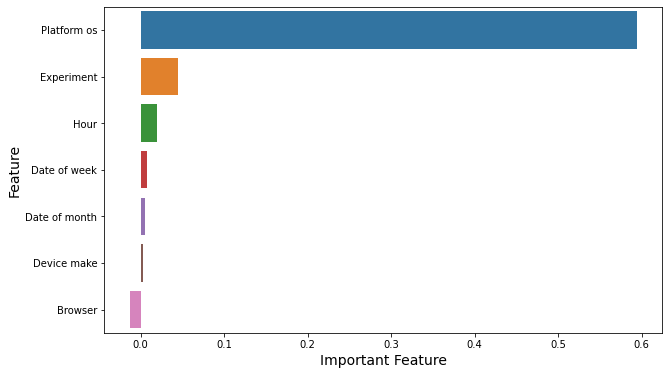

In [11]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Important Feature", y=imp_featur.index, data=imp_featur)
plt.ylabel('Feature', fontsize=14)
plt.xlabel('Important Feature', fontsize=14)
plt.show()

In the plot above we can see the importance of each feature on brand awareness. 
The Platform os is the important feature for brand awerness.

### XGBoost

In [12]:
xgboost_model= pickle.load(open("../models/xgboost_model.pickle", "rb"))
xgboost_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, ...)

#### Confusion Matrix

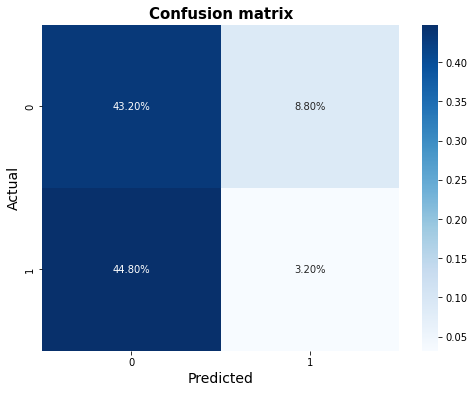

In [13]:
y_preds = xgboost_model.predict(test_feature)
plot_confusion_metrics(test_labels, y_preds)


In [14]:
imp_featur = pd.DataFrame({"Important Feature": xgboost_model.feature_importances_})
imp_featur['Feature'] = feature_columns
imp_featur = imp_featur.set_index('Feature')
imp_featur = imp_featur.sort_values(by=['Important Feature'], ascending=False)
imp_featur


,Important Feature
Feature,
Device make,0.20
Date of week,0.18
Date of month,0.17
Experiment,0.16
Hour,0.16
Browser,0.12
Platform os,0.00


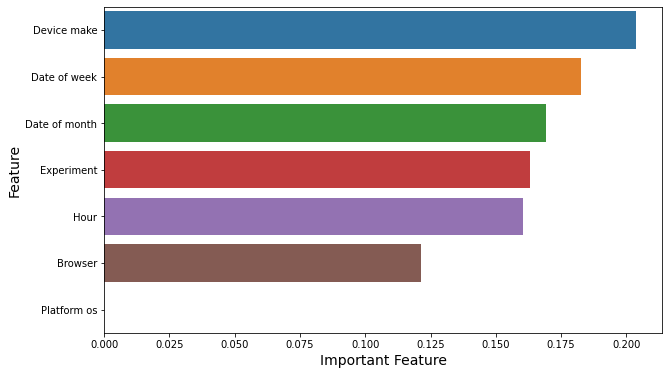

In [15]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Important Feature", y=imp_featur.index, data=imp_featur)
plt.ylabel('Feature', fontsize=14)
plt.xlabel('Important Feature', fontsize=14)
plt.show()

In the above we can see that the features has almost the same role in determaining brand awerness.



#### Decision Tree Classifier


In [16]:
dec_model =  pickle.load(open("../models/decision_tree_model.pickle", "rb"))
dec_model

DecisionTreeClassifier(max_depth=2, random_state=42)

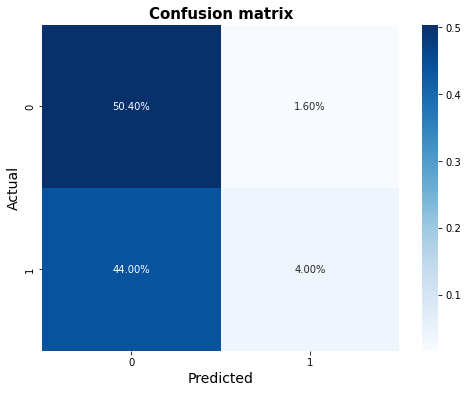

In [17]:
y_preds = dec_model.predict(test_feature)
plot_confusion_metrics(test_labels, y_preds)


In [18]:
imp_featur = pd.DataFrame({"Important Feature": dec_model.feature_importances_})
imp_featur['Feature'] = feature_columns
imp_featur = imp_featur.set_index('Feature')
imp_featur = imp_featur.sort_values(by=['Important Feature'], ascending=False)
imp_featur


,Important Feature
Feature,
Device make,0.43
Hour,0.35
Date of month,0.22
Experiment,0.00
Date of week,0.00
Platform os,0.00
Browser,0.00


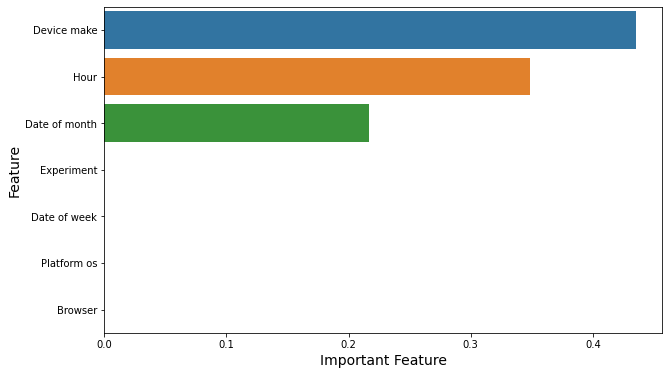

In [19]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Important Feature", y=imp_featur.index, data=imp_featur)
plt.ylabel('Feature', fontsize=14)
plt.xlabel('Important Feature', fontsize=14)
plt.show()

The Device Make, Hour, Date of month are the only features for determining brand awareness. The experiment feature has no importance in dermining brand awareness.

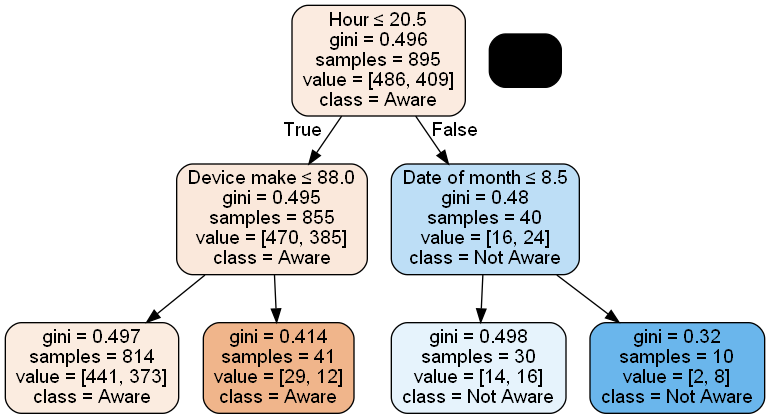

In [20]:
dot_data = tree.export_graphviz(
  dec_model, 
  out_file="resume.dot",
  feature_names=feature_columns, 
  class_names=['Aware', 'Not Aware'],
  filled=True, 
  rounded=True, 
  special_characters=True, 
  leaves_parallel=False)
graph = pydotplus.graphviz.graph_from_dot_file("resume.dot")
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [21]:
reg_model =  pickle.load(open("../models/random_forest_model.pickle", "rb"))
reg_model

RandomForestClassifier(random_state=42)

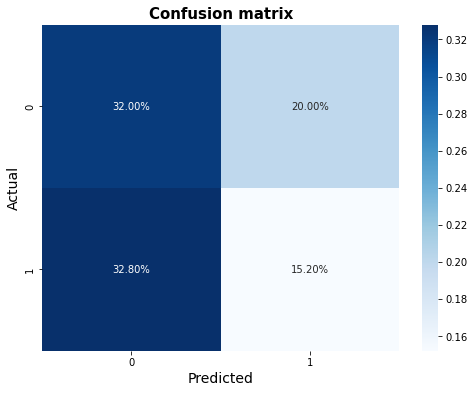

In [23]:
y_preds = reg_model.predict(test_feature)
plot_confusion_metrics(test_labels, y_preds)

In [24]:
imp_featur = pd.DataFrame({"Important Feature": reg_model.feature_importances_})
imp_featur['Feature'] = feature_columns
imp_featur = imp_featur.set_index('Feature')
imp_featur = imp_featur.sort_values(by=['Important Feature'], ascending=False)
imp_featur

,Important Feature
Feature,
Hour,0.43
Device make,0.28
Browser,0.09
Date of week,0.08
Date of month,0.08
Experiment,0.04
Platform os,0.00


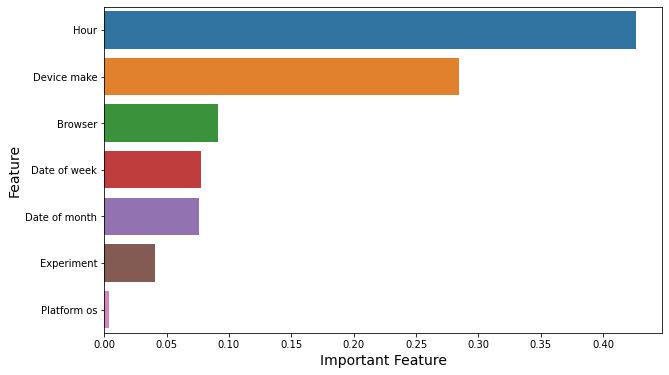

In [25]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Important Feature", y=imp_featur.index, data=imp_featur)
plt.ylabel('Feature', fontsize=14)
plt.xlabel('Important Feature', fontsize=14)
plt.show()

In the plot above we can see the importance of each feature on brand awareness. 
The Hour is the important feature for brand awerness.

We are able to calculate the feature importance in all the machine learning A/B testing. from the result we can see that Experiment feature is not the most important feature in determaining the brand awareness. So we can see that we are not able to get a accurate score in the models.



## Results

The results we get from all the machine learning algorithms we can see that we did not collect enough information. 